In [1]:
"""
Provenance Replay Python API tutorial/examples

Here's a brief walkthrough of some common or useful uses of Provenance Replay available through the Python 3 API.
Please be aware that Provenance Replay is currently available in an alpha release, and these concepts and commands
may change in the future.

# Please feel free to post questions to the QIIME 2 Forum's Community Plugin Support channel.
# Mentioning me there @ChrisKeefe will help me respond more quickly.
"""

"\nProvenance Replay Python API tutorial/examples\n\nHere's a brief walkthrough of some common or useful uses of Provenance Replay available through the Python 3 API.\nPlease be aware that Provenance Replay is currently available in an alpha release, and these concepts and commands\nmay change in the future.\n\n# Please feel free to post questions to the QIIME 2 Forum's Community Plugin Support channel.\n# Mentioning me there @ChrisKeefe will help me respond more quickly.\n"

In [2]:
import provenance_lib

In [3]:
# provenance_lib exposes one-shot commands that produce common reproducibility outputs

# ? provenance_lib.replay_provenance
# ? provenance_lib.replay_citations
? provenance_lib.replay_supplement

In [4]:
# Here, we parse only the .qza and .qzv files that are directly contained in the target directory,
# producing a zip archive of reproducibility documentation we can share.

# ALWAYS unzip and review the supplement to make sure you're not sharing confidential metadata
# or analyses accidentally

provenance_lib.replay_supplement('../provenance_lib/tests/data/parse_dir_test', './supp.zip')

parsing ../provenance_lib/tests/data/parse_dir_test/v5_uu_emperor.qzv
metadata written to recorded_metadata/
python3 replay script written to python3_replay.py
metadata written to recorded_metadata/
cli replay script written to cli_replay.sh
citations bibtex file written to citations.bib
reproducibility package written to /home/chris/src/provenance_lib/docs/supp.zip


In [5]:
# Here, with recurse=True, we recurse into all subdirectories, parsing all .qza and .qzv files in the file tree
# Note the additional Archives being parsed.
provenance_lib.replay_supplement(payload='../provenance_lib/tests/data/parse_dir_test', out_fp='./supp.zip', recurse=True)

parsing ../provenance_lib/tests/data/parse_dir_test/v5_uu_emperor.qzv
parsing ../provenance_lib/tests/data/parse_dir_test/inner/v5_table.qza
parsing ../provenance_lib/tests/data/parse_dir_test/inner/v5_unrooted_tree.qza
metadata written to recorded_metadata/
python3 replay script written to python3_replay.py
metadata written to recorded_metadata/
cli replay script written to cli_replay.sh
citations bibtex file written to citations.bib
reproducibility package written to /home/chris/src/provenance_lib/docs/supp.zip


In [6]:
# users with more advanced needs can build and manipulate provenance
# graphs (ProvDAG objects) directly
? provenance_lib.ProvDAG

In [7]:
# ProvDAG contains a networkx.DiGraph object in its .dag property
dag_1 = provenance_lib.ProvDAG(artifact_data='../provenance_lib/tests/data/parse_dir_test', recurse=False)
dag_2 = provenance_lib.ProvDAG(artifact_data='../provenance_lib/tests/data/parse_dir_test/inner/', recurse=False)

# We can ask some simple questions about it, like...
# How many nodes (UUIDs) are in the provenance graph?
print(len(dag_1))
print(len(dag_2))

# Which QIIME 2 Results were parsed to produce this ProvDAG?
# This returns a set of unique artifact identifiers (UUIDs)
print(dag_1.parsed_artifact_uuids)
print(dag_2.parsed_artifact_uuids)


15
8
{'ffb7cee3-2f1f-4988-90cc-efd5184ef003'}
{'12e012d5-b01c-40b7-b825-a17f0478a02f', '89af91c0-033d-4e30-8ac4-f29a3b407dc1'}


In [8]:
? provenance_lib.ProvDAG.union

In [9]:
# We can combine ProvDAGs with union
unioned = provenance_lib.ProvDAG.union([dag_1, dag_2])

# Nodes are not duplicated during graph union - each unique node is represented once.
# dag_1 and dag_2 share some common nodes, so:
print(len(unioned))
assert(len(unioned) <= len(dag_1) + len(dag_2))

# The nodes parsed separately above are all of the nodes contained by the directory
# we're parsing recursively here.
parsed_recursively = provenance_lib.ProvDAG(
    artifact_data='../provenance_lib/tests/data/parse_dir_test',
    recurse=True)

# As a result:
print(len(parsed_recursively))
assert(unioned == parsed_recursively)

16
16


In [10]:
# The repr lists the UUIDs of all artifacts passed in by the user for parsing
print(unioned, '\n')

# Recursive parsing captures the UUIDs of all .qza and .qzv files in the passed directories.
print(parsed_recursively)

ProvDAG representing these Artifacts {'12e012d5-b01c-40b7-b825-a17f0478a02f', 'ffb7cee3-2f1f-4988-90cc-efd5184ef003', '89af91c0-033d-4e30-8ac4-f29a3b407dc1'} 

ProvDAG representing these Artifacts {'12e012d5-b01c-40b7-b825-a17f0478a02f', 'ffb7cee3-2f1f-4988-90cc-efd5184ef003', '89af91c0-033d-4e30-8ac4-f29a3b407dc1'}


In [11]:
# After unioning multiple dags, we can still produce the same outputs
# (citations, provenance, or a full reproducibility supplement) from them.
# In fact, we can use the same command we used above, but hand it the ProvDAG instead of a file path.

# THIS from above: provenance_lib.replay_supplement('./parse_dir_test', './supp.zip') becomes
provenance_lib.replay_supplement(unioned, './supp.zip')

# It's super snappy, too, because the parsing's already been done.

metadata written to recorded_metadata/
python3 replay script written to python3_replay.py
metadata written to recorded_metadata/
cli replay script written to cli_replay.sh
citations bibtex file written to citations.bib
reproducibility package written to /home/chris/src/provenance_lib/docs/supp.zip


In [12]:
# What if we want to visualize our DAG?
# Support is currently limited, and visual inspection is rarely useful
# with large graphs, but we can lean on networkx and matplotlib to plot

# TOP SECRET: These graphs are ugly. This section is mostly an excuse to
# show GraphViews and node relabeling. Ssshhhhhh!

# Basic setup for plotting
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

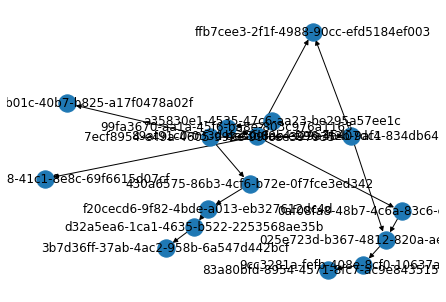

In [13]:
# Here goes nothing!
nx.draw(unioned.dag, with_labels=True)
plt.show()

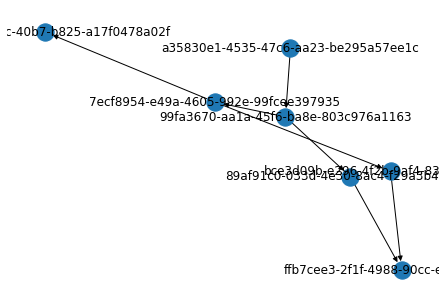

In [14]:
# We can clean this up a bit, though.
# First, remember that ProvDAG.dag is comprehensive, it includes all historical provenance nodes
# including all of the results from actions run internally by the QIIME 2pipelines we use
# If we want a view more like Q2View's presentation, we can use a graphview.

user_actions_only = unioned.collapsed_view
nx.draw(user_actions_only, with_labels=True)
plt.show()

In [15]:
# That's a bit better. Now we can see that ffb7cee3 is a terminal node (no out-edges)
# and with some more looking, we could find the source nodes too.
# NetworkX offers for these sorts of things that are much more effective than visual inspection.

# but what if we don't like the full UUIDs as labels?
? provenance_lib.ProvDAG.relabel_nodes

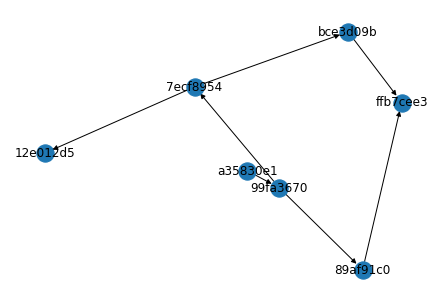

In [16]:
# We'll use copy=True, so we don't mess up our original ProvDAG.
rl_dag = unioned.relabel_nodes(mapping={node: node[0:8] for node in unioned}, copy=True)
rl_collapsed = rl_dag.collapsed_view
nx.draw(rl_collapsed, with_labels=True)
plt.show()

# If it looks super weird, try re-running this cell a couple times.
# It might look less weird. A method for visualizing ProvDAGs
# in an orderly fashion could be a useful addition to provenance_lib,
# if you're interested in contributing!

In [17]:
# Thanks for taking the time to look this over. I hope you found it useful!